# Image Classification Using Convolutional Neural Networks

## 패션 MNIST 데이터 불러오기

- Data scale을 0~255 사이에서 0~1로 바꿈
- train, validation set으로 나눔
- Input Image는 항상 Depth가 있어야 함
  - 흑백 이미지의 경우 channel 차원이 없는 2차원 배열
  - Conv2D Layer를 사용하기 위해 마지막에 channel 차원을 추가해야 함
  - numpy의 reshape() 메서드를 사용해 전체 배월 차원을 유지하면서 마지막에 차원 추가

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = \
keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1,28,28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


- (48000, 28, 28) size -> (48000, 28, 28, 1) size인 `train_sacled` 만듦

## 합성곱 신경망 만들기

In [2]:
# 32개의 filter 사용
# (28,28,1)로 변경
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28, 28, 1)))

In [3]:
# pooling layer 추가
model.add(keras.layers.MaxPooling2D(2))

- (2,2) pooling을 적용하여 feature map의 크기는 반으로 줄어듦
- feature map의 size는 (14, 14, 32)이 됨

In [4]:
# 64개의 filter 늘림
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

- (2,2) pooling을 적용하여 feature map의 크기는 반으로 줄어듦
- feature map의 size는 (7, 7, 64)이 됨

In [5]:
# 3차원 feature map을 일렬로 펼칠 차례
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

- Dropout layer가 hidden layer의 overfitting을 막아 성능을 개선해 줌
- hidden layer는 100개의 neuran을 사용
- activation function은 `ReLU` 사용
- Fashion MNIST dataset은 class 10개를 분류하는 multi-classification 문제임
- 따라서 마지막 층의 activation function은 `Softmax` 사용

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

- feature map의 크기는 input data (28, 28, 32) 에서 (14, 14, 32) -> (14, 14, 64) -> (7, 7, 64)로 변경

### Parameter 수 계산
- 32개의 filter, size (3,3), depth 1, filter 마다 1개의 bias

#### 첫 번째 Conv 층
- $3$x$3$x$1$x$32$+$32$=$320$

#### 두 번째 Conv 층
- $3$x$3$x$32$x$64$+$64$=$18496$

</br>

Flatten 클래스에서 (7,7,64) 크기의 feature map을 1차원 배열로 펼치면 (3136,) 크기의 배열이 됩니다.

이를 100개의 Neuran과 완전히 연결해야 하므로 hidden layer의 model parameter 수는 3,316 x 100 + 100 으로 313,700이 됩니다.

마지막 출력층의 model parameter 수는 1,010개입니다.


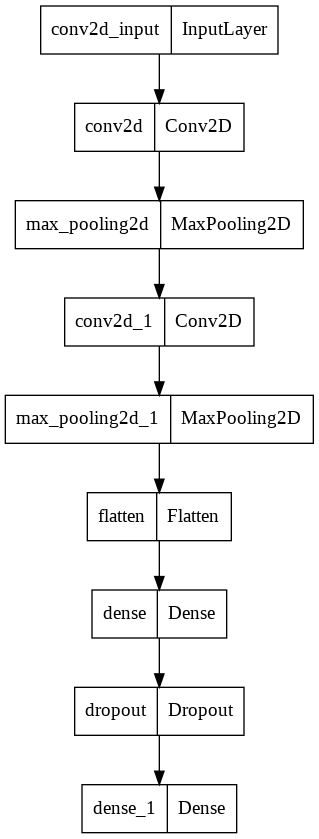

In [7]:
# 왼쪽은 layer 이름, 오른쪽은 class
keras.utils.plot_model(model)

- `InputLayer` 클래스에는 keras가 자동으로 추가해주는 것으로 input layer의 역할
- 이 input layer는 첫 번째 Conv2D 클래스에 추가한 `input_sahpe` 매개변수 사용

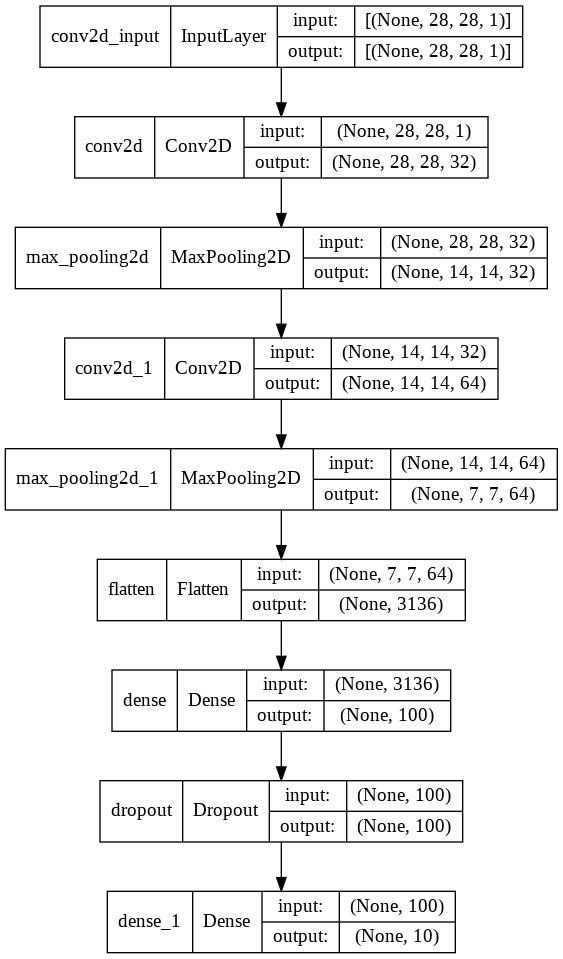

In [8]:
keras.utils.plot_model(model, show_shapes=True)

지금까지 만든 신경망을 그림으로 나타내면

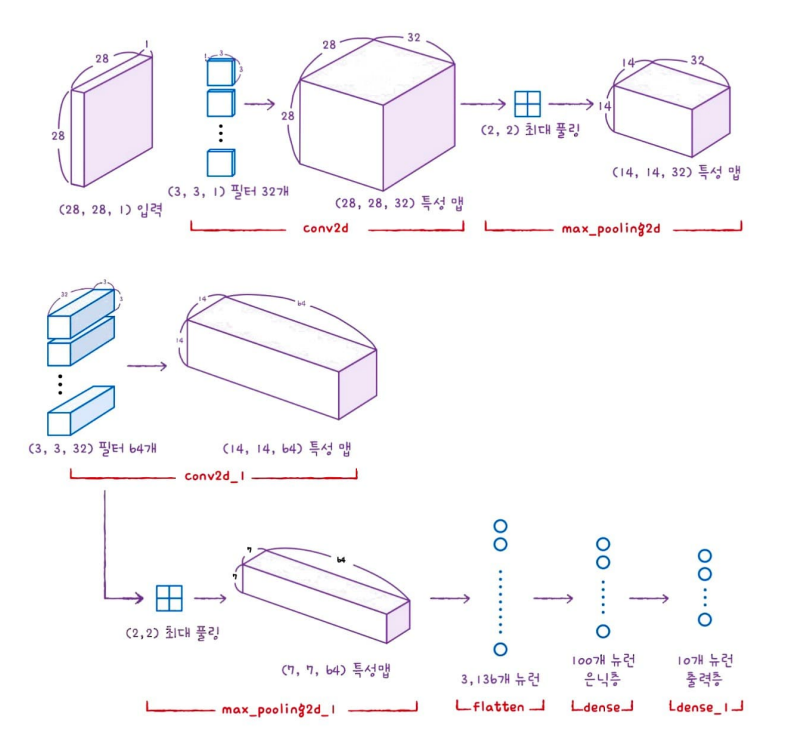

## 모델 컴파일과 훈련

In [9]:
# Adam optimizer 사용, ModelCheckpoint 콜백, EarlyStopping 콜백 사용해 조기 종료 기법 구현
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 19s 7ms/step - loss: 0.5190 - accuracy: 0.8152 - val_loss: 0.3293 - val_accuracy: 0.8817
Epoch 2/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3459 - accuracy: 0.8755 - val_loss: 0.2741 - val_accuracy: 0.8992
Epoch 3/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2941 - accuracy: 0.8937 - val_loss: 0.2461 - val_accuracy: 0.9095
Epoch 4/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2603 - accuracy: 0.9060 - val_loss: 0.2402 - val_accuracy: 0.9107
Epoch 5/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2351 - accuracy: 0.9138 - val_loss: 0.2300 - val_accuracy: 0.9154
Epoch 6/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2173 - accuracy: 0.9210 - val_loss: 0.2312 - val_accuracy: 0.9150
Epoch 7/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1991 - accuracy: 0.9257 - val_loss: 0.2244 - val_ac

In [12]:
import matplotlib.pyplot as plt

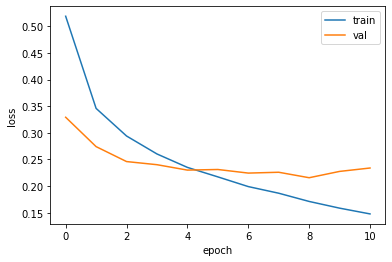

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [11]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 4ms/step - loss: 0.2157 - accuracy: 0.9235


[0.21571604907512665, 0.9235000014305115]

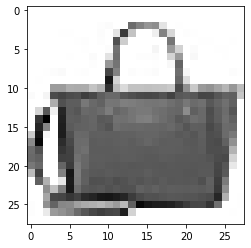

In [16]:
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [17]:
preds = model.predict(val_scaled[0:1])
print(preds)

[[5.3512411e-18 2.9849149e-29 1.3369937e-24 6.8090087e-24 1.4942635e-24
  2.8263387e-23 2.5510210e-21 2.0967526e-17 1.0000000e+00 8.5371936e-22]]


**슬라이싱**을 사용한 이유

> predict() 메서드에 데이터를 전달할 때, val_scaled[0]을 쓰지 않고 val_scaled[0:1]로 사용함

> - keras의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대

> - 샘플을 전달할 때 (28,28,1)이 아니라 (1,28,28,1) 크기를 전달

> - 배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1,28,28,1) 크기 만듦


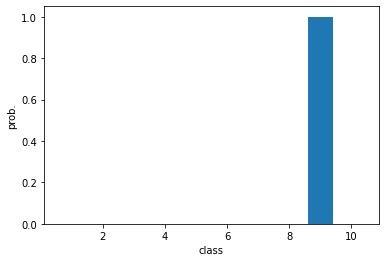

In [19]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [20]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [21]:
import numpy as np
print(classes[np.argmax(preds)])

가방


- train set과 validation set에서 했던 것처럼 pixel 값의 범위를 0~1 사이로 바꾸고 이미지 크기를 (28,28) 에서 (28,28,1)로 바꿈

In [22]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

- evaluate() 메서드로 test set에 대해 성능 측정

In [23]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 6ms/step - loss: 0.2382 - accuracy: 0.9207


[0.2382250428199768, 0.9207000136375427]

## Summary

### Conv2D
입력의 너비와 높이 방향의 합성곱 연산을 구현한 클래스

- `kernal_size`: 필터의 커널 크기 지정
- `strides`: 필터의 이동 간격 지정
- `padding`: 입력의 패딩 타입 지정
  - `valid`
  - `same`
- `activation`: 활성화 함수 지정

### MaxPooling2D
입력의 너비와 높이를 줄이는 풀링 연산 구현

### plot_model()
keras model 구조를 그려줌

- `to_file`: 매개변수에 파일 이름을 지정하면 그림 파일 저장
- `show_shapes`: True로 지정하면 layer의 input, output size 표시
- `show_layer_names`: True로 지정하면 layer 이름 출력

### Matplotlib

- `bar()`: 막대그래프 출력
- 첫 번째 매개변수에 x축의 값을 리스트나 넘파이 배열로 전달
- 두 번째 매개변수에 막대의 y축 값을 리스트나 넘파이 배열로 전달
- `width` 매개변수에 막대의 두께 지정(기본값 0.8)